# RQ3

How does the embedding model influence resource and energy use?

In [116]:
%load_ext autoreload
%autoreload 2

import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from results_processor import get_experiments_data, compute_total_energy_per_run, get_ci_deviation, compute_wilcoxon

plt.style.use("ggplot")
colors = sns.cubehelix_palette(start=2, rot=0.1, dark=0.2, light=.95, reverse=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
experiments_data = get_experiments_data(
    "rq3",
    ["Total DRAM Power [W]", "IA Cores Power [W]", "GPU Rail Powers (avg) [W]"],
)

runs_data = compute_total_energy_per_run(experiments_data)

In [31]:
embedding_variation_runs = []

for embedding_model_name, data in runs_data.items():
    data_embedding_variation = copy.deepcopy(data["measurements_per_run"])
    data_embedding_variation["duration [s]"] = data["durations_per_run"]
    data_embedding_variation["embedding_model"] = embedding_model_name.replace(
        "_nfcorpus", ""
    ).replace("_", "-")

    embedding_variation_runs.append(data_embedding_variation)

embedding_variation_runs = pd.concat(embedding_variation_runs)

In [88]:
embedding_variation_runs.groupby("embedding_model").aggregate(
    lambda x: str(round(x.mean(), 2)) + " ± " + str(get_ci_deviation(x))
)

,IA Cores Energy [J],DRAM Energy [J],GPU Energy [J],duration [s]
embedding_model,,,,
gte-base,1549.46 ± 5.51,150.71 ± 0.5,7232.06 ± 23.11,242.31 ± 0.37
gte-large,3960.83 ± 109.72,374.26 ± 4.55,17926.52 ± 22.39,621.28 ± 0.37
gte-small,647.81 ± 2.69,63.64 ± 0.3,2183.68 ± 12.04,89.62 ± 0.09


In [89]:
total_consumption_per_embedding_type = embedding_variation_runs.groupby(
    "embedding_model"
).sum()
total_consumption_smallest_embedding = (
    embedding_variation_runs.groupby("embedding_model").sum().iloc[2, :]
)

consumption_ratio = (
    total_consumption_per_embedding_type / total_consumption_smallest_embedding
)
consumption_ratio = consumption_ratio.sort_values("duration [s]")
consumption_ratio

,IA Cores Energy [J],DRAM Energy [J],GPU Energy [J],duration [s]
embedding_model,,,,
gte-small,1.000000,1.000000,1.000000,1.000000
gte-base,2.391835,2.368152,3.311866,2.703557
gte-large,6.114158,5.880715,8.209313,6.932061


In [90]:
embedding_model = consumption_ratio.index.to_list() * len(consumption_ratio.columns)

consumption_ratio = consumption_ratio.melt()
consumption_ratio["embedding_model"] = embedding_model

Text(0.5, 1.0, 'Measurements in relation with gte-small embedding model')

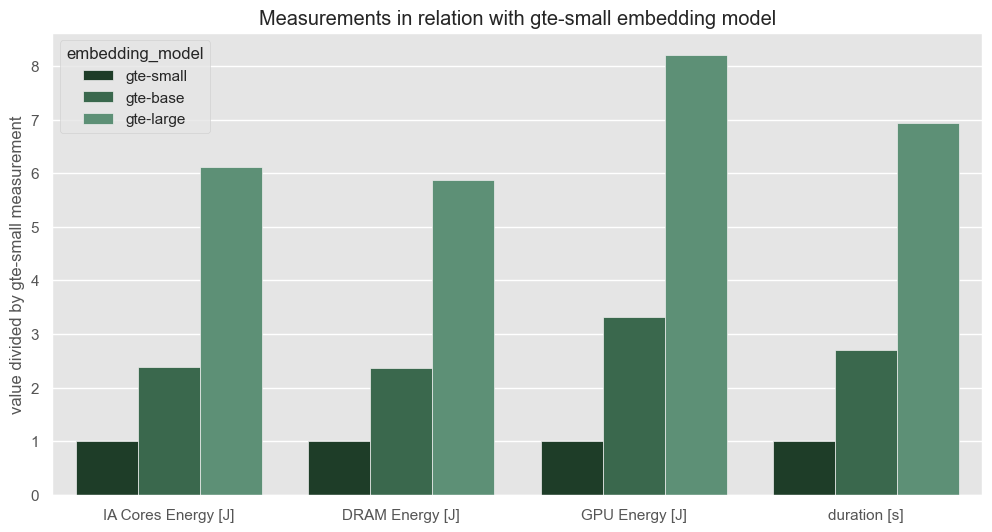

In [138]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)
sns.barplot(consumption_ratio, x="variable", y="value", hue="embedding_model", palette=colors)
plt.ylabel("value divided by gte-small measurement")
plt.xlabel("")
plt.title("Measurements in relation with gte-small embedding model")

In [119]:
compute_wilcoxon(embedding_variation_runs, "gte-small", "gte-base", "GPU Energy [J]")

WilcoxonResult(statistic=np.float64(0.0), pvalue=np.float64(0.0009765625))

In [118]:
compute_wilcoxon(embedding_variation_runs, "gte-base", "gte-large", "GPU Energy [J]")

WilcoxonResult(statistic=np.float64(0.0), pvalue=np.float64(0.0009765625))

In [120]:
compute_wilcoxon(embedding_variation_runs, "gte-small", "gte-base", "duration [s]")

WilcoxonResult(statistic=np.float64(0.0), pvalue=np.float64(0.0009765625))

In [121]:
compute_wilcoxon(embedding_variation_runs, "gte-base", "gte-large", "duration [s]")

WilcoxonResult(statistic=np.float64(0.0), pvalue=np.float64(0.0009765625))